### prescoring создание прескоринга с помощью нескольких фичей

- Количество договоров (всех закрытых и действующих), 
- Количество закрытых договоров, 
- Количество договоров c признаками плохого завершения', 
- Максимальная длительность закрытых договоров, 
- Минимальная длительность закрытых договоров, 
- Количество договоров c признаками плохого завершения

Входные данные 
- data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи на target
- data/interm/accounts_status.pkl с общей категорией

In [114]:
import pandas as pd

In [115]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [116]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))
# target_features.head(1)

Размер считанных данных target_class with mdm features- (85798, 39)


In [117]:
name = pre + "data/interm/features_mdm.pkl"
features_mdm = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных mdm features- {}".format(features_mdm.shape))
# features_mdm.head(1)

Размер считанных данных mdm features- (229912, 29)


In [118]:
name = pre + "data/interm/accounts_status.pkl"
accounts_status = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных о контрагентах (сводно из crm и 1c) - {}".format(accounts_status.shape))
# accounts_status.head(1)

Размер считанных данных о контрагентах (сводно из crm и 1c) - (737858, 4)


In [119]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/prescoring_part2.xlsx"
writer = ExcelWriter(name)

#### Теперь формируем выборки для фрод и дефолта

In [120]:
# target_features.head()

In [121]:
target_frod = Target(type='фрод', target_data=target_features) # это фрод дефолт, макс по обращению

# target_frod.print_param()

кред дефолт у нас под хорошего попадает

In [122]:
# pd.crosstab(target_frod.data['Метка фрод дефолта'], target_frod.data['Метка кред дефолта'])
# pd.crosstab(target_frod.data['Метка дефолта'], target_frod.data['Метка кред дефолта'])

In [123]:
#  смотрим на статусы наших контрагентов
clients_status = pd.merge(features_mdm, accounts_status, how='left', left_on=['new_lessee_inn'], right_on=['inn'])

clients_status['Статус_контрагента'] = clients_status['Статус_контрагента'].fillna('Не является нашим клиентом')
clients_status['Статус_общ'] = clients_status['Статус_общ'].fillna('Не является нашим клиентом')

# определяем дубликаты по ID
num, duplicates = identify_duplicates(features_mdm, 'new_lessee_inn')
Check_dupl(num, duplicates)

# clients_status.sample(1)

In [124]:
df = pd.pivot_table(clients_status, index='Статус_общ',  values='new_lessee_inn',  aggfunc='count', margins=True, fill_value= 0)\
    .rename(columns={'new_lessee_inn':'Количество ИНН'})
df['Доля, %'] = round(df['Количество ИНН']/df['Количество ИНН']['All']*100,2)
# df

## Обучение модели на target
В качестве выбранных фичей берем log regression на двух фичах: 
- 'no_contracts_total' - "Количество договоров до дня принятия решения" на Фрод выборке
- 'duration_max' - "максимальная длительность закрытых договоров"

log regression выбрана из-за того, что в сDecisionTree ниже recall, а для прескоринга именно recall имеет наибольшее значение (ниже ложноотприцательный результат)ч

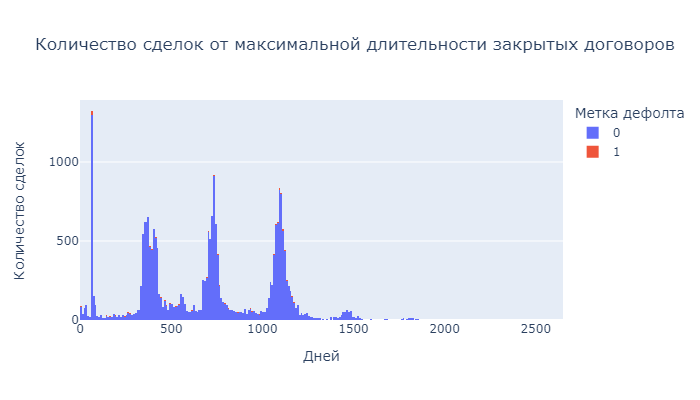

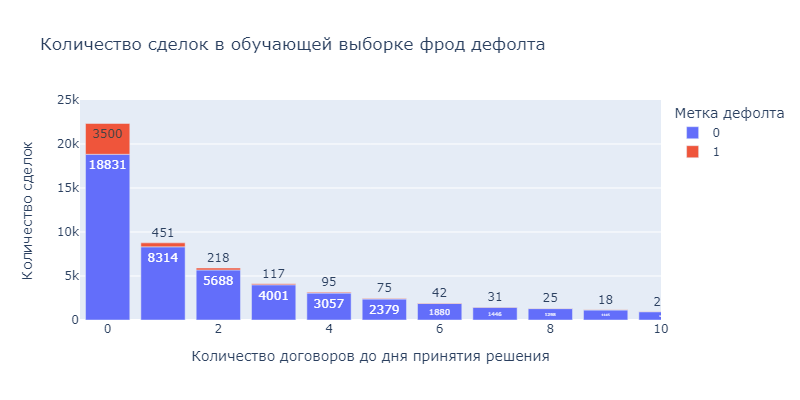

In [129]:
df = target_frod.data.copy().reset_index()
fig1 = show_duration(df, x='duration_max', title='Количество сделок от максимальной длительности закрытых договоров')
fig2 = plot_features_bar(df, 'no_contracts_total', x_range =[-0.5, 10], y_range =[0, 25000])

<!-- вывод статического изображения для тех browsers, в которых не видны интерактивные 
<img src='../../data/img/prescoring2_deals_versus_maxdur.png'> 
<img src='../../data/img/prescoring2_deals_in_total.png'>  -->

In [92]:
target_data = target_frod.data.copy()
for delta_col in target_data.columns:
    if (is_timedelta64_dtype(target_data[delta_col])):
       target_data[delta_col] = target_data[delta_col].dt.days
       target_data[delta_col] = target_data[delta_col].fillna(0)

for delta_col in clients_status.columns:
    if (is_timedelta64_dtype(clients_status[delta_col])):
       clients_status[delta_col] = clients_status[delta_col].dt.days
       clients_status[delta_col] = clients_status[delta_col].fillna(0)

# target_data.head(1)

In [93]:
target_data[['no_contracts_total', 'duration_max']].describe()

,no_contracts_total,duration_max
count,63131.000000,63131.000000
mean,6.835089,257.026247
std,20.331700,403.157542
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,0.000000
75%,6.000000,423.000000
max,824.000000,2641.000000


Перед обучением убирем, те приложения, значения которых являются нетипичными

In [94]:
cut_contracts = 30
mask_contracts = (target_data['no_contracts_total']<=cut_contracts)
tmp = target_data[~mask_contracts]
print("Всего приложений в target {}, из них выпадают по количеству договоров {}".format(len(target_data), len(tmp)))

cut_duration = 1500
mask_duration = (target_data['duration_max']<=cut_duration)
tmp = target_data[~mask_duration]
print("Всего приложений в target {}, из них выпадают по макс продолжительность {}".format(len(target_data), len(tmp)))

train_data = target_data[mask_duration & mask_contracts].copy()
print("Всего приложений в target {}, из них в обучающей выборке будет {}".format(len(target_data), len(train_data)))

Всего приложений в target 63131, из них выпадают по количеству договоров 2840
Всего приложений в target 63131, из них выпадают по макс продолжительность 191
Всего приложений в target 63131, из них в обучающей выборке будет 60194


{'rocauc': 0.66, 'accuracy': 0.44, 'recall': 0.92}
{'intercept': -0.0775, 'coef': array([-0.2831, -0.2924])}


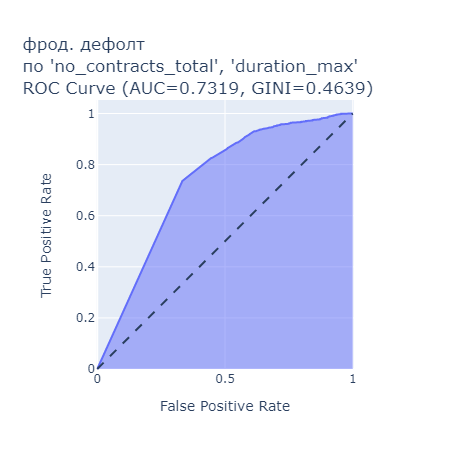

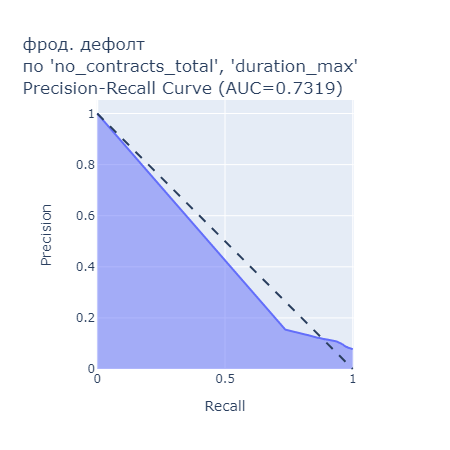

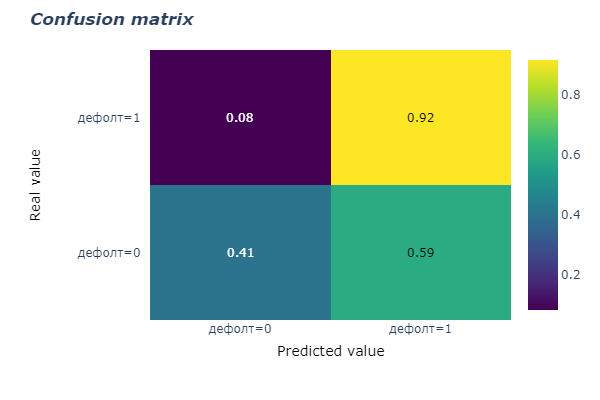

In [95]:
type = target_frod.type

X_raw = np.asarray(train_data[['no_contracts_total', 'duration_max']])
y = np.asarray(train_data['Метка дефолта'])

log = LogRegCV(X_raw, y, norm=True)

log.print_metrics()
log.print_coef()
fig_roc_auc = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +"по 'no_contracts_total', 'duration_max'")
fig_precision_recall = log.plot_precision_recall(title = '{}. дефолт'.format(type) + '<br>' +"по 'no_contracts_total', 'duration_max'")
fig_mat = log.plot_confusion_matrix(normalize='true')

   
# вычислим на всех данных target какая вероятность дефолта
X = np.asarray(target_data[['no_contracts_total', 'duration_max']])

y_pred, y_prob = log.predict(X)
target_data['proba'] = y_prob

## Сразу удалим тех контрагентов, у которых есть плохие завершения и слишком короткие договоры, как подозрительные

Подозрительными будем считать, 
- у кого были плохие завершения ('reason_гибель/тотал', 'reason_расторгнут', 'reason_страховой случай (гибель/тотал)')
- у кого были закрытые договора, и минимальная длительность менее 200 дней

In [96]:
print(len(clients_status))
mask_closed = (clients_status['no_contracts_closed']>0)
mask_duration = (clients_status['duration_min']<200)
mask_bad = (clients_status['bad_reasons_closed']>0)

suspicious_clients = clients_status[mask_bad | (mask_closed & mask_duration)]
clients = clients_status[~(mask_bad | (mask_closed & mask_duration))].reset_index(drop=True)

print("Всего контрагентов в mdm {}, из них подозрительных {}, оставляем {} ".format(len(clients_status), len(suspicious_clients), len(clients)))


229912
Всего контрагентов в mdm 229912, из них подозрительных 19863, оставляем 210049 


In [97]:
# если не убирать подозрительные
# clients = clients_status

## Делаем prediction на данных mdm по обученной модели balanced

In [98]:
X_raw = np.asarray(clients[['no_contracts_total', 'duration_max']])
y_pred, y_prob = log.predict(X_raw)
clients['proba'] = y_prob
clients['pred'] = y_pred

keep_col = ['new_lessee_inn', 'no_contracts_total', 'duration_max', 'Статус_общ',	'is_in_bmd',	'proba', 'pred']
mdm_predicted = clients[keep_col].copy()

mdm_predicted['pred'] = mdm_predicted['pred'].astype(int).astype(str)
# mdm_predicted.head(1)

теперь построим распределение

In [99]:
df_inn = pd.pivot_table(mdm_predicted, index=['no_contracts_total', 'duration_max'], values='new_lessee_inn', aggfunc='count', )\
            .rename(columns={'new_lessee_inn':'Количество ИНН'}).reset_index()

df = mdm_predicted.drop_duplicates(subset=['no_contracts_total', 'duration_max', 'proba', 'pred'])
df = pd.merge(df, df_inn, how='left', on=['no_contracts_total', 'duration_max'])
df['size'] = np.log(df['Количество ИНН'])*50

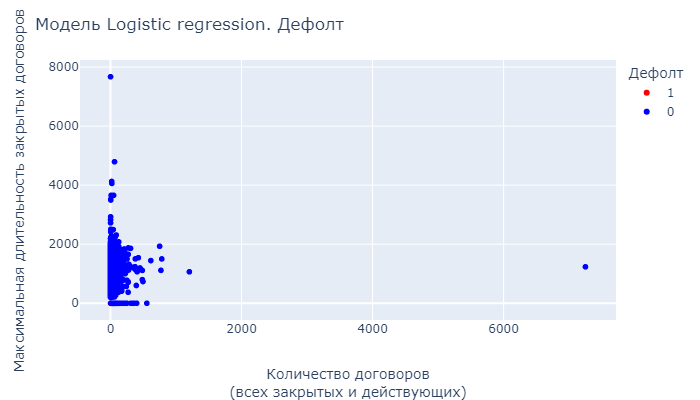

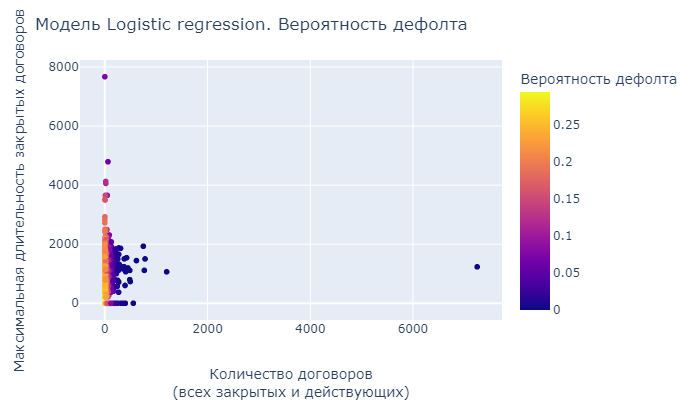

In [100]:
fig = show_model_multifactors(df, x_feature='no_contracts_total', y_feature='duration_max', 
                              title='Модель Logistic regression. Дефолт', color='pred')

fig = show_model_multifactors(df, x_feature='no_contracts_total', y_feature='duration_max', 
                              title='Модель Logistic regression. Вероятность дефолта', color='proba')

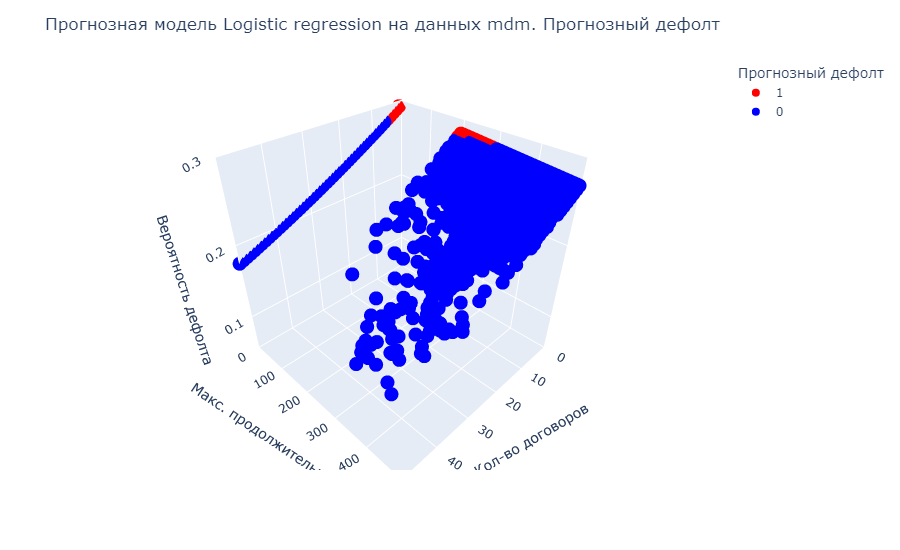

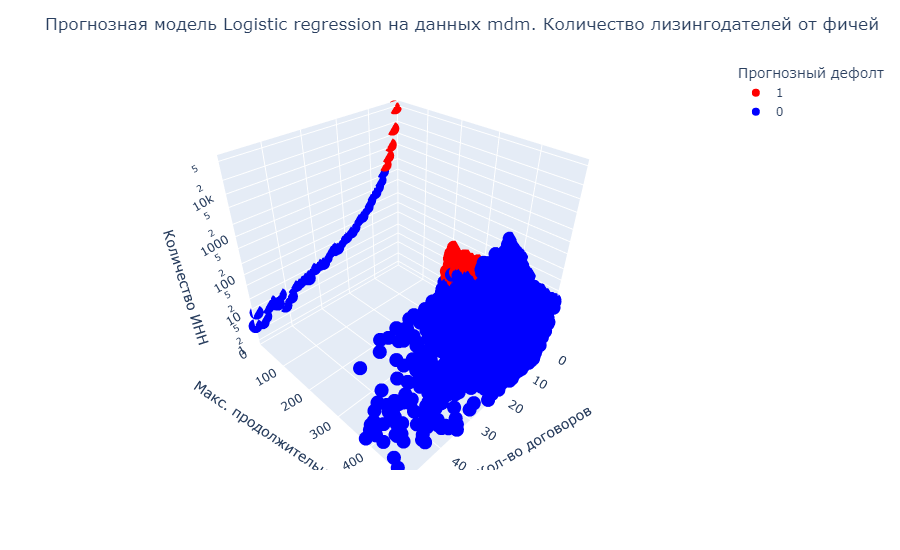

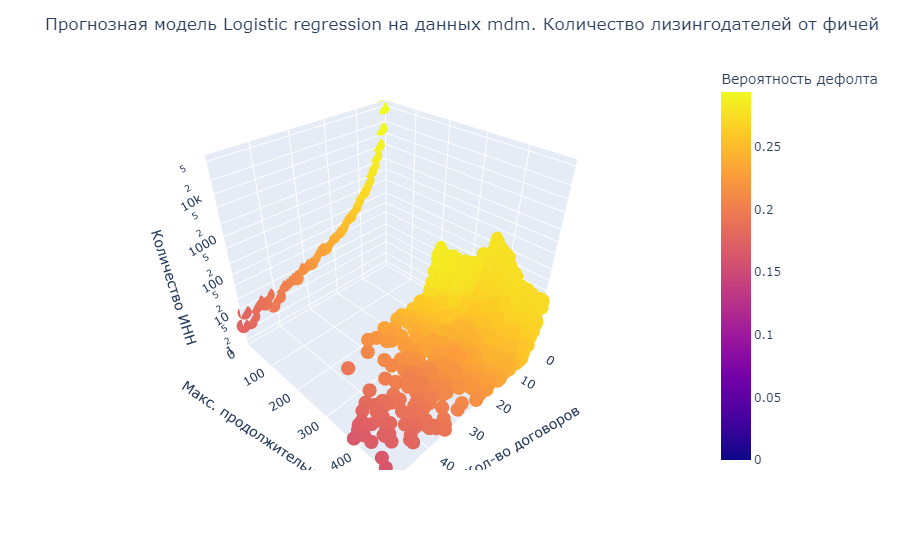

In [101]:
fig = show_model_multifactors_3d(df, title='Прогнозная модель Logistic regression на данных mdm. Прогнозный дефолт', z='proba', color='pred')
fig = show_model_multifactors_3d(df, title='Прогнозная модель Logistic regression на данных mdm. Количество лизингодателей от фичей', z='Количество ИНН', color='pred')
fig = show_model_multifactors_3d(df, title='Прогнозная модель Logistic regression на данных mdm. Количество лизингодателей от фичей', z='Количество ИНН', color='proba')


## Считаем долю дефолта и другие метрики качества на target данных суммарно в пуле
$Доля Дефолта(proba(Количество Договоров; Максимальная Продолжительность)<prob)$



In [102]:
keep_col = ['Приложение',  'no_contracts_total', 'duration_max', 'Метка дефолта', 'proba']
target_data = target_data[keep_col].copy()
# target_data.head()

In [103]:
df_metrics = pd.DataFrame(columns=['proba', 'Доля_дефолта_в_target'])
max_range = int(target_data['proba'].max()*10000) + 2
share_of_fraud_last = 0

for step in tqdm(range(max_range)):
    proba = step / 10000

    mask = (target_data['proba']<=proba)
    target_data.loc[mask, 'y_pred'] = 0
    target_data.loc[~mask, 'y_pred'] = 1

    good = target_data[mask]
    if (len(good)==0):
        continue
    share_of_fraud = good['Метка дефолта'].sum()/len(good)
    if abs(share_of_fraud_last-share_of_fraud)<0.0001:
        continue
    share_of_fraud_last = share_of_fraud
    d = {'proba': proba, 'Доля_дефолта_в_target':share_of_fraud}
    df_metrics = df_metrics.append(d, ignore_index=True)
    
df_metrics["Доля_дефолта_в_target_proc"] = df_metrics["Доля_дефолта_в_target"]*100

  1%|          | 27/2970 [00:00<00:11, 262.98it/s]

100%|██████████| 2970/2970 [00:09<00:00, 300.52it/s]


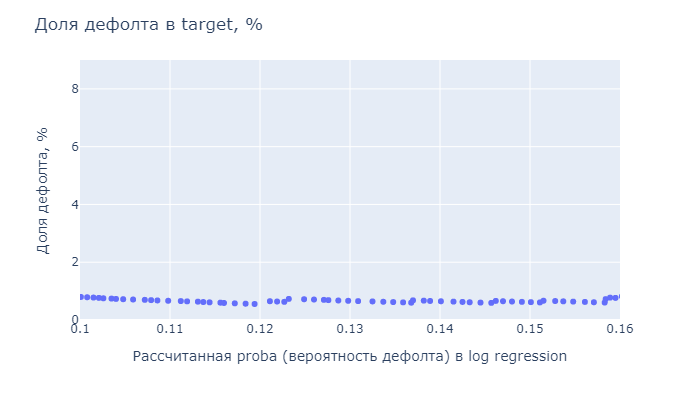

In [104]:
fig = show_share_target(df_metrics)

определим proba для 2% в пуле

In [105]:
cut_proba = df_metrics[df_metrics['Доля_дефолта_в_target_proc']<=2]['proba'].max()
cut_proba

0.2885

## расчет количества контрагентов в базе mdm при различных proba

In [106]:
num, duplicates = identify_duplicates(df_metrics, 'proba')
Check_dupl(num, duplicates)
df_metrics.head(1)

,proba,Доля_дефолта_в_target,Доля_дефолта_в_target_proc
0,0.0005,0.125,12.5


In [107]:
df_inn_quantity = pd.DataFrame(columns=['proba', 'Количество ИНН', 'Статус_общ'])

for step in tqdm(range(15, 31)):
    
    proba = step / 200
    mask = (mdm_predicted['proba']<=proba)
    pre_score = mdm_predicted[mask]

    df = pd.pivot_table(pre_score, index='Статус_общ',  values='new_lessee_inn', aggfunc='nunique', fill_value= 0)\
            .rename(columns={'new_lessee_inn':'Количество ИНН'}).reset_index()
    df['proba'] = proba

    # # перерасчитаем долю дефолта, так как шаг proba тут иной
    mask = (target_data['proba']<=proba)

    good = target_data[mask]
    if (len(good)==0):
        share_of_fraud = 100
    else:
        share_of_fraud = round(good['Метка дефолта'].sum()/len(good)*100, 2)
   
    df['share_of_fraud'] = share_of_fraud
    
    df_inn_quantity = df_inn_quantity.append(df, ignore_index=True)

df_inn_quantity['Количество ИНН'] = df_inn_quantity['Количество ИНН'].astype(int)

df_inn_quantity.sample(1) 

100%|██████████| 16/16 [00:00<00:00, 63.16it/s]


,proba,Количество ИНН,Статус_общ,share_of_fraud
160,0.145,84,Не было передачи в лизинг,0.6


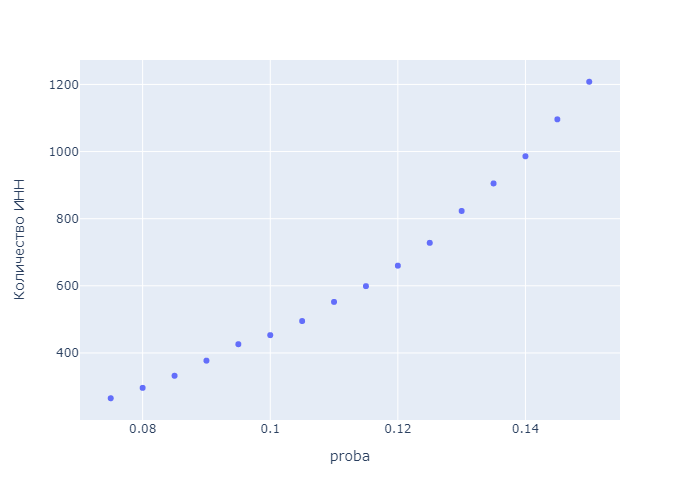

In [108]:
df = pd.pivot_table(df_inn_quantity, index='proba',  values='Количество ИНН', aggfunc='sum', fill_value= 0).reset_index()
fig = px.scatter(df, x="proba", y="Количество ИНН", )
fig.show('png' if need_svg else '')

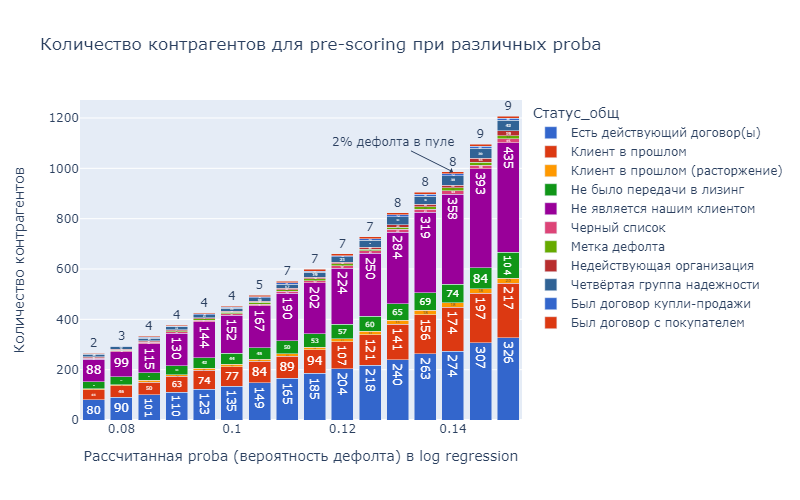

In [109]:
fig_clients_versus_boundary = show_clients_for_prescoring_proba(df_inn_quantity, color='Статус_общ', annot_boundary=0.14)

### распределение лизингополучателей при 2% дефолта в пуле (proba= 0.145)

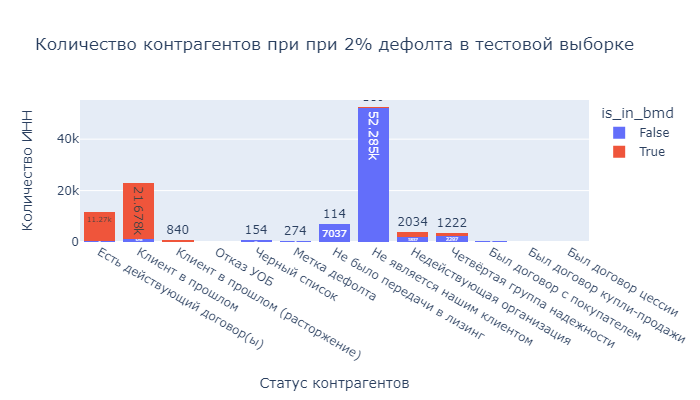

In [110]:

proba = cut_proba

# tmp = df_metrics[df_metrics['proba']==proba][['proba', 'Доля_дефолта_в_target_proc']]
# metrics = html_side_by_side(tmp, titles=['Качество при отсечении количества договоров от 4 и более'])
# display_html(metrics, raw=True)

mask = (mdm_predicted['proba']<=proba)
pre_score = mdm_predicted[mask]

fig_proba = show_clients_boundary_fix(pre_score, title = "Количество контрагентов при при 2% дефолта в тестовой выборке")
# fig_boundary_4.write_html(pre+'data/html/boundary4.html')

## Сохранение результатов

In [111]:
good_clients = mdm_predicted[mdm_predicted['Статус_общ'].isin(['Не является нашим клиентом', 'Есть действующий договор(ы)', 'Клиент в прошлом', 'Не было передачи в лизинг'])].copy()

proba = cut_proba

mask = (good_clients['proba']<=proba)
pre_score = good_clients[mask].copy()
print(proba, pre_score.shape)

pre_score['proba'] = round(pre_score['proba'], 4)

pre_score[['new_lessee_inn', 'Статус_общ', 'is_in_bmd', 'proba']].to_pickle(pre+"data/processed/good_clients.pkl".format(proba), compression={'method':'zip'})
pre_score[['new_lessee_inn', 'Статус_общ', 'is_in_bmd', 'proba']].to_csv(pre+"data/processed/good_clients.csv".format(proba), index=False)

0.2885 (131465, 7)


In [112]:
# pre_score.head()

In [113]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()